# Phase 4 NLP ML Project


![Image Description](Image/Twitter1.png)

# Activate Env

In [1]:
conda activate TFgpu


Note: you may need to restart the kernel to use updated packages.


# Load Python Packages & DF

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
import re

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text_list, tokenizer, stopwords_list, remove_words):
    '''
    Takes in a list of strings, a tokenizer, a list of stopwords, and a list of words to remove.
    Returns a list of lowercased, tokenized, stopwords-removed, and lemmatized words.
    '''
    # lowercase
    lower = [str(text).lower() for text in text_list]

    # tokenize
    tokenized = [tokenizer.tokenize(tweet) for tweet in lower]

    # stopwords and special characters
    no_stops = []
    for item in tokenized:
        temp = []
        for token in item:
            if token not in stopwords_list and token not in remove_words:
                # Remove special characters
                token = re.sub(r'\W+', '', token)
                temp.append(token)
        no_stops.append(temp)

    # preparation for lemmatization
    tags = [pos_tag(tokens) for tokens in no_stops]

    better_tags = []
    for item in tags:
        temp1 = []
        for word in item:
            temp1.append((word[0], get_wordnet_pos(word[1])))
        better_tags.append(temp1)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    lem = []
    for item in better_tags:
        temp2 = []
        for word in item:
            temp2.append(lemmatizer.lemmatize(word[0], word[1]))
        lem.append(temp2)

    preprocessed = [' '.join(i) for i in lem]

    return preprocessed

# Read the dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

# Remove tweets with unknown sentiment
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

# Load and preprocess the data
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the tokenizer and stopwords list
tokenizer = TweetTokenizer()
stopwords_list = stopwords.words('english')





# Define the words to remove
remove_words = ['sxsw', 'rt', 'mention']  # Add your own words to remove here





# Create the pipeline for the dummy model
dummy_pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
    ('tfidf', TfidfVectorizer()),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

# Create the pipeline for the ensemble model
ensemble_pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text, kw_args={'tokenizer': tokenizer, 'stopwords_list': stopwords_list, 'remove_words': remove_words})),
    ('tfidf', TfidfVectorizer()),
    ('classifier', VotingClassifier(
        estimators=[
            ('nb', MultinomialNB(alpha=0.1)),
            ('svm', SVC(kernel='linear', probability=True)),
            ('rf', RandomForestClassifier(n_estimators=100))
        ],
        voting='soft'
    ))
])

# Train the dummy model
dummy_pipeline.fit(X_train, y_train)

# Make predictions using the dummy model
y_pred_dummy = dummy_pipeline.predict(X_test)

# Train the ensemble model
ensemble_pipeline.fit(X_train, y_train)

# Make predictions using the ensemble model
y_pred_ensemble = ensemble_pipeline.predict(X_test)

# Calculate evaluation metrics for the dummy model
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
recall_dummy = recall_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)
f1_dummy = f1_score(y_test, y_pred_dummy, average='weighted', zero_division=1.0)

# Calculate evaluation metrics for the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='weighted', zero_division=1.0)
recall_ensemble = recall_score(y_test, y_pred_ensemble, average='weighted', zero_division=1.0)
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted', zero_division=1.0)

# Print the evaluation metrics for the dummy model
print(f'DummyClassifier Accuracy: {accuracy_dummy}')
print(f'DummyClassifier Precision: {precision_dummy}')
print(f'DummyClassifier Recall: {recall_dummy}')
print(f'DummyClassifier F1-score: {f1_dummy}')

# Print the evaluation metrics for the ensemble model
print(f'Ensemble Accuracy: {accuracy_ensemble}')
print(f'Ensemble Precision: {precision_ensemble}')
print(f'Ensemble Recall: {recall_ensemble}')
print(f'Ensemble F1-score: {f1_ensemble}')


DummyClassifier Accuracy: 0.6124161073825504
DummyClassifier Precision: 0.7626373811990451
DummyClassifier Recall: 0.6124161073825504
DummyClassifier F1-score: 0.4652068245465783
Ensemble Accuracy: 0.6884787472035794
Ensemble Precision: 0.6723214185166567
Ensemble Recall: 0.6884787472035794
Ensemble F1-score: 0.668198165995472


In [60]:
from collections import Counter

# Clean the text data
X_cleaned = clean_text(X, tokenizer, stopwords_list, remove_words)

# Tokenize the cleaned text
tokens = [token for tweet_tokens in X_cleaned for token in tokenizer.tokenize(tweet_tokens)]

# Remove the words specified for removal
tokens_filtered = [token for token in tokens if token not in remove_words]

# Count the frequency of each word
word_counts = Counter(tokens_filtered)

# Get the top 10 most common words and their frequencies
top_words = word_counts.most_common(30)

# Extract the words
words = [word for word, _ in top_words]

# Print the top 10 words
print("Top 30 Words:")
for word in words:
    print(word)


Top 30 Words:
link
ipad
google
apple
2
iphone
store
new
austin
launch
app
get
circle
social
popup
android
today
open
network
go
line
via
party
call
free
mobile
come
sxswi
one
time


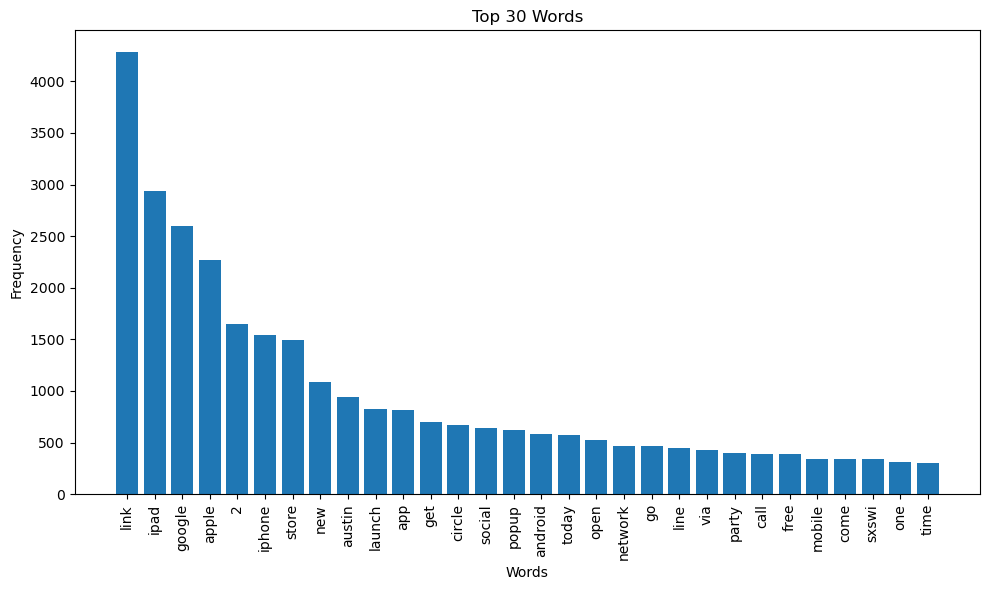

In [61]:
import matplotlib.pyplot as plt

# Top 10 words and their frequencies
top_words = word_counts.most_common(30)
words, frequencies = zip(*top_words)

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


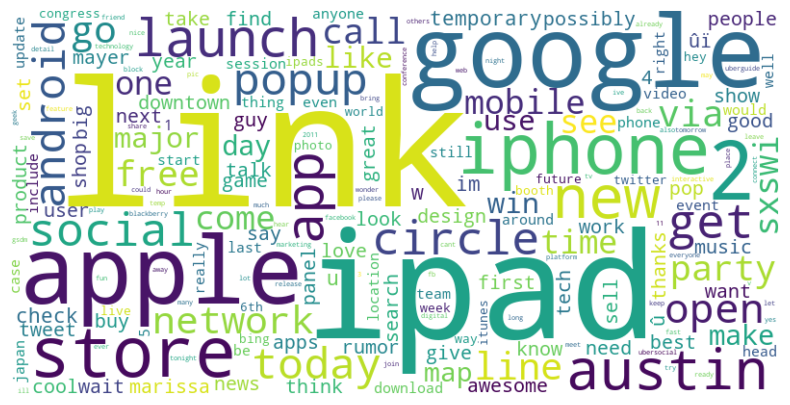

In [62]:

# Clean the text data
X_cleaned = clean_text(X, tokenizer, stopwords_list, remove_words)

# Tokenize the cleaned text
tokens = [token for tweet_tokens in X_cleaned for token in tokenizer.tokenize(tweet_tokens)]

# Remove the words specified for removal
tokens_filtered = [token for token in tokens if token not in remove_words]

# Create a frequency dictionary of the filtered words
word_freq = {}
for word in tokens_filtered:
    word_freq[word] = word_freq.get(word, 0) + 1

# Generate the word cloud based on the word frequency
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Fit the Multinomial Naive Bayes model
nb.fit(X_train_preprocessed, y_train)

# Get the feature log probabilities for each class
feature_log_probs = nb.feature_log_prob_

# Calculate the exponential of the feature log probabilities
feature_probs = np.exp(feature_log_probs)

# Access the feature importance scores for each class
class_importances = feature_probs

# Define the feature names (assuming you're using TfidfVectorizer)
feature_names = preprocessor.get_feature_names_out()

top_n = 30  # Specify the number of top features to display

# Get the class names from the model
class_names = nb.classes_

# Create separate figures and axes for each class
figs = []
axes = []
for i in range(class_importances.shape[0]):
    fig, ax = plt.subplots(figsize=(10, 6))
    figs.append(fig)
    axes.append(ax)

    # Sort the features by importance
    class_importance_sorted = class_importances[i].argsort()[-top_n:][::-1]

    # Plot the top N features and their importances
    ax.barh(np.array(feature_names)[class_importance_sorted], class_importances[i][class_importance_sorted])

    # Customize the plot
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Multinomial Naive Bayes - Class {class_names[i]} - Top {top_n} Features')

    # Adjust the layout
    plt.tight_layout()

# Show the plots
plt.show()


NameError: name 'nb' is not defined

# Model 2 Analysis - Supervised Machine Learning Algorithm

In [34]:
model2.fit(X_train_preprocessed, y_train)
coefficients = model2.coef_

In [35]:
coefficients

<3x7418 sparse matrix of type '<class 'numpy.float64'>'
	with 13922 stored elements in Compressed Sparse Row format>

In [36]:
# ABS Value below graph

In [37]:
top_n = 10  # Specify the number of top features to display

# Sort the features by the absolute magnitude of coefficients for each class
class_sorted_indices = np.argsort(np.abs(coefficients), axis=1)[:, -top_n:]

# Reverse the order of the sorted indices
class_sorted_indices = np.flip(class_sorted_indices, axis=1)

# Get the top N features and their corresponding coefficients
top_features = np.array(feature_names)[class_sorted_indices]
top_coefficients = np.take_along_axis(coefficients, class_sorted_indices, axis=1)

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the top N features and their coefficients for each class
for i in range(coefficients.shape[0]):
    ax.barh(top_features[i], top_coefficients[i], label=f'Class {i}')

# Customize the plot
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Feature')
ax.set_title('Linear SVM - Top 10 Features')
ax.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


ValueError: WRITEBACKIFCOPY base is read-only

In [38]:
import matplotlib.pyplot as plt

top_n = 30  # Specify the number of top features to display

# Sort the features by the absolute magnitude of coefficients for each class
class_sorted_indices = np.argsort(np.abs(coefficients), axis=1)[:, -top_n:]

# Reverse the order of the sorted indices
class_sorted_indices = np.flip(class_sorted_indices, axis=1)

# Get the top N features and their corresponding coefficients
top_features = np.array(feature_names)[class_sorted_indices]
top_coefficients = np.take_along_axis(coefficients, class_sorted_indices, axis=1)

# Get the class names
class_names = model1.classes_

# Get the number of classes
num_classes = coefficients.shape[0]

# Create separate figures and axes for each class
figs = []
axes = []
for i in range(num_classes):
    fig, ax = plt.subplots(figsize=(20, 12))
    figs.append(fig)
    axes.append(ax)

# Plot the top N features and their coefficients for each class
for i in range(num_classes):
    ax = axes[i]
    ax.barh(top_features[i], top_coefficients[i], label=f'Class {class_names[i]}')
    ax.set_xlabel('Coefficient Value', fontsize=30)  # Increase font size for x-axis label
    ax.set_ylabel('Feature', fontsize=20)  # Increase font size for y-axis label
    ax.set_title(f'Linear SVM - {class_names[i]} - Top {top_n} Features', fontsize=25)  # Increase font size for title
    ax.legend(fontsize=14)  # Increase font size for legend
    ax.tick_params(axis='both', labelsize=16)  # Increase font size for tick labels
    plt.tight_layout()

# Show the plots
plt.show()


ValueError: WRITEBACKIFCOPY base is read-only

# Model 3 Analysis - Random Forest Model

In [39]:
model3.fit(X_train_preprocessed, y_train)
importances = model3.feature_importances_

In [40]:
importances

array([3.97835628e-04, 3.22059873e-04, 2.33880592e-06, ...,
       2.24398297e-06, 4.50572458e-08, 6.22548638e-05])

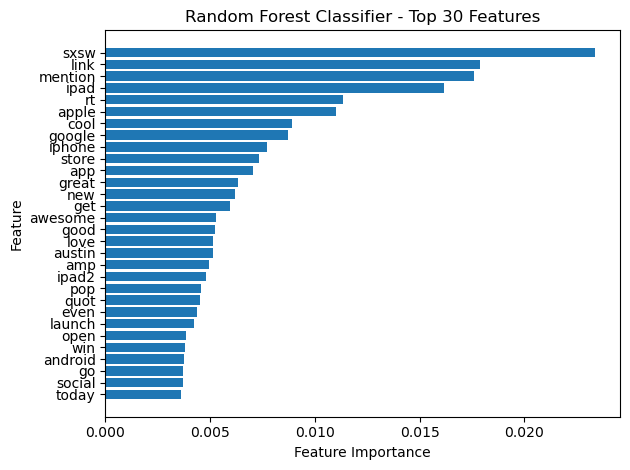

In [41]:
import matplotlib.pyplot as plt

# Fit the Random Forest Classifier model
model3.fit(X_train_preprocessed, y_train)

# Get the feature importances
importances = model3.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(importances)

# Get the top N features and their importances
top_n = 30  # Specify the number of top features to display
top_features = feature_names[sorted_indices][-top_n:]
top_importances = importances[sorted_indices][-top_n:]

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the top N features and their importances
ax.barh(top_features, top_importances)

# Customize the plot
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('Random Forest Classifier - Top 30 Features')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


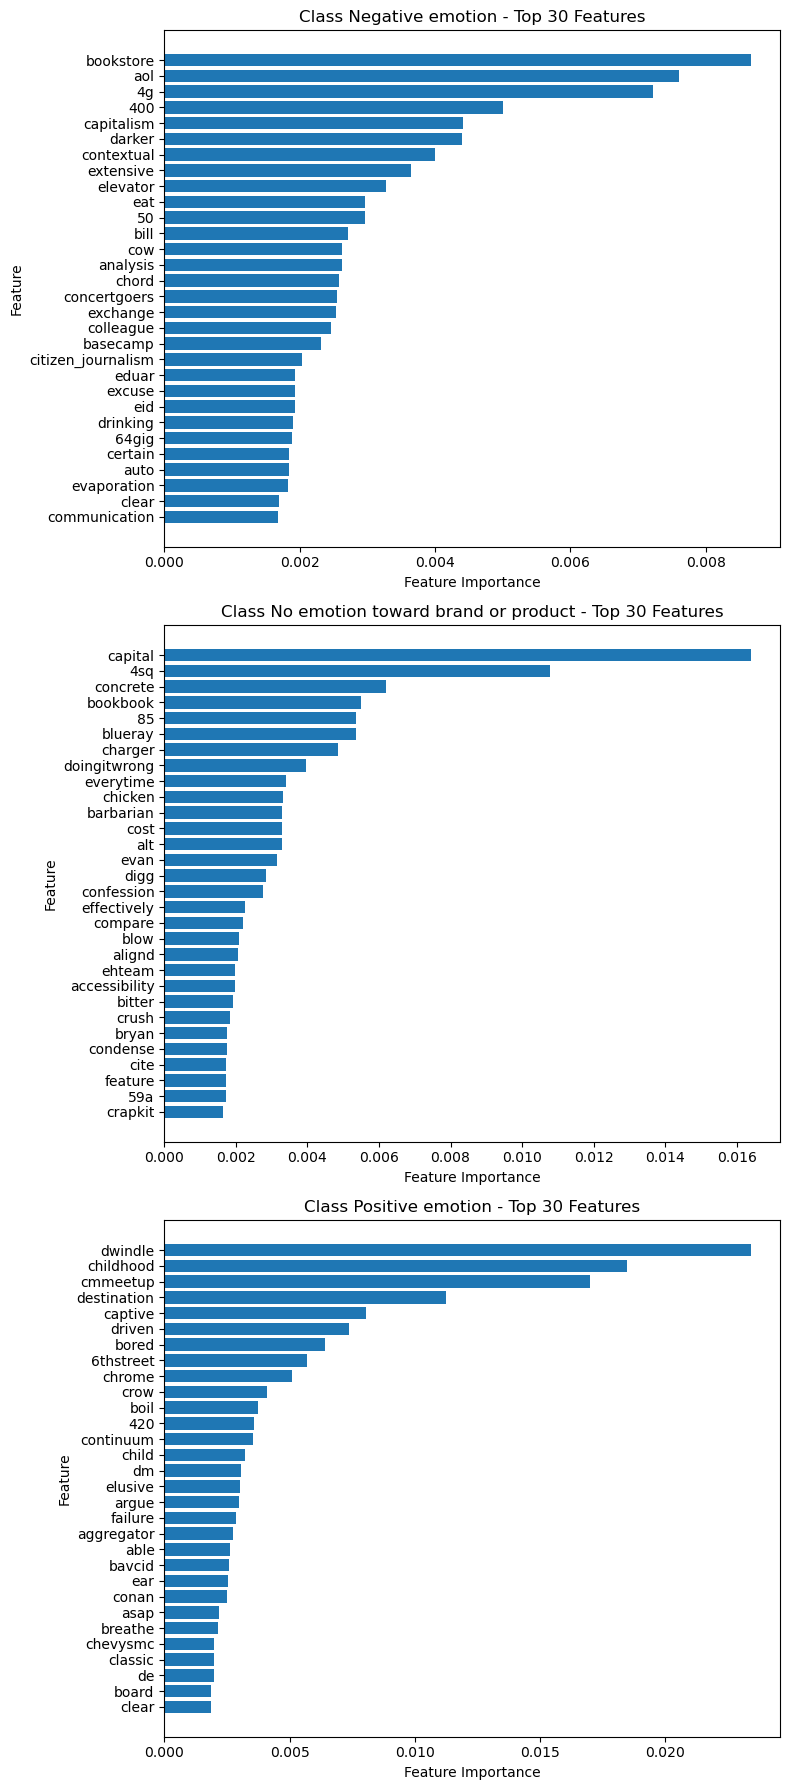

In [42]:
import matplotlib.pyplot as plt

# Fit the Random Forest Classifier model
model3.fit(X_train_preprocessed, y_train)

# Get the feature importances
importances = model3.feature_importances_

# Get the number of classes
num_classes = len(model3.classes_)

# Create a figure with subplots for each class
fig, axes = plt.subplots(nrows=num_classes, figsize=(8, 6 * num_classes))

# Iterate over each class
for i, class_label in enumerate(model3.classes_):
    # Get the feature importances for the current class
    class_importances = importances[i::num_classes]

    # Get the indices of features sorted by importance
    sorted_indices = np.argsort(class_importances)

    # Get the top N features and their importances
    top_n = 30  # Specify the number of top features to display
    top_features = feature_names[sorted_indices][-top_n:]
    top_importances = class_importances[sorted_indices][-top_n:]

    # Create the subplot for the current class
    ax = axes[i]

    # Plot the top N features and their importances for the current class
    ax.barh(top_features, top_importances)

    # Set the subplot title
    ax.set_title(f'Class {class_label} - Top {top_n} Features')

    # Set the subplot xlabel
    ax.set_xlabel('Feature Importance')

    # Set the subplot ylabel
    ax.set_ylabel('Feature')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
